# HF Pairs Trading on NSE — Analysis Notebook

### This notebook loads KPI CSVs and reproduces summary plots and tables.


In [1]:
%pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 12.8 MB/s eta 0:00:00


In [2]:
### Synthetic data generation → pair-level & portfolio-level CSVs:


import os, math
import numpy as np
import pandas as pd
BASE_DIR = "data/"
os.makedirs(BASE_DIR, exist_ok=True)
np.random.seed(42)

# Synthetic universe: 10 focal pairs across sectors
pairs = [
    ("RELIANCE", "BPCL", "Energy"),
    ("HDFCBANK", "ICICIBANK", "Financials"),
    ("INFY", "TCS", "IT"),
    ("HINDUNILVR", "NESTLEIND", "Consumer"),
    ("TATASTEEL", "JSWSTEEL", "Materials"),
    ("LT", "SIEMENS", "Industrials"),
    ("BHARTIARTL", "HDFCLIFE", "Telecom"),
    ("MARUTI", "TATAMOTORS", "Auto"),
    ("AXISBANK", "KOTAKBANK", "Financials"),
    ("ITC", "BRITANNIA", "Consumer"),
]

tick_sizes = [5, 15, 30, 60]
models = ["Classical", "Preferred"]
pair_selection = ["Ranked", "Random"]
carry = ["Carry", "EOD_Flat"]
cointegration_check = ["RollingCheck", "SkipCheck"]
exec_delay_ticks = [0, 1]
param_grid_size = 16

rows = []
for (a, b, sector) in pairs:
  for ts in tick_sizes:
    for m in models:
      for sel in pair_selection:
        for c in carry:
          for ci in cointegration_check:
            for d in exec_delay_ticks:
              base_sr = 0.6
              base_ret = 0.08
              if m == "Preferred":
                 base_sr += 0.5; base_ret += 0.12
              if sel == "Ranked":
                 base_sr += 0.3; base_ret += 0.05
              if c == "Carry":
                 base_sr += 0.05; base_ret += 0.02
              if ci == "SkipCheck":
                 base_sr += 0.05; base_ret += 0.03
              if d == 1:
                 base_sr *= 0.7
                 base_ret *= 0.6  # ~40% reduction
              if ts == 5: base_ret += 0.02
              if ts == 60: base_ret -= 0.01

              sr = max(0.1, np.random.normal(base_sr, 0.1))
              ann_ret = max(-0.2, np.random.normal(base_ret, 0.03))
              invested_return = ann_ret * np.random.uniform(0.7, 1.0)
              trades = int(np.random.normal(180 if ts==5 else 60, 15))
              hit_rate = np.clip(np.random.normal(0.55 if m=="Preferred" else 0.5, 0.05), 0.2, 0.9)
              mdd = np.clip(np.random.normal(0.12, 0.03), 0.05, 0.3)
              holding = np.clip(np.random.normal(45 if ts==60 else 20, 5), 5, 120)

              rows.append({
                  "pair_a": a, "pair_b": b, "sector": sector,
                  "tick_minutes": ts, "model": m, "pair_selection": sel,
                  "position_policy": c, "cointegration_policy": ci,
                  "exec_delay_ticks": d, "param_grid_size": param_grid_size,
                  "sharpe": round(sr, 2),
                  "committed_return_annual": round(ann_ret, 4),
                  "invested_return_annual": round(invested_return, 4),
                  "num_trades": trades, "hit_rate": round(hit_rate, 3),
                  "max_drawdown": round(mdd, 3),
                  "avg_holding_minutes": round(holding, 1),

              })


pair_kpis = pd.DataFrame(rows)


def portfolio_summary(df, model="Preferred", sel="Ranked", delay=1):
  sub = df[(df["model"]==model)&(df["pair_selection"]==sel)&(df["exec_delay_ticks"]==delay)]

  return {

        "model": model,
        "pair_selection": sel,
        "exec_delay_ticks": delay,
        "portfolio_sharpe": round(sub["sharpe"].mean(), 2),
        "portfolio_committed_return_annual": round(sub["committed_return_annual"].mean(), 4),
        "portfolio_invested_return_annual": round(sub["invested_return_annual"].mean(), 4),
        "total_trades": int(sub["num_trades"].sum()),
        "avg_hit_rate": round(sub["hit_rate"].mean(), 3),
        "avg_max_drawdown": round(sub["max_drawdown"].mean(), 3),
        "capital_per_pair_inr": 100000,
        "num_pairs": 10,
        "portfolio_notional_inr": 100000*10
  }


portfolio_kpis = pd.DataFrame([
    portfolio_summary(pair_kpis, "Preferred", "Ranked", 1),
    portfolio_summary(pair_kpis, "Classical", "Random", 1),
    portfolio_summary(pair_kpis, "Preferred", "Ranked", 0),
        ])

pair_csv = os.path.join(BASE_DIR, "pair_level_kpis.csv")
port_csv = os.path.join(BASE_DIR, "portfolio_kpis.csv")
pair_kpis.to_csv(pair_csv, index=False)
portfolio_kpis.to_csv(port_csv, index=False)

print("******************************************")
print("Pair CSV:", pair_csv)
print("\n******************************************")
print(pair_kpis.head())
print("******************************************\n")
print("******************************************\n")

print("Portolio CSV:", port_csv)

print("******************************************\n")
print(portfolio_kpis)

print("******************************************\n")






******************************************
Pair CSV: data/pair_level_kpis.csv

******************************************
     pair_a pair_b  sector  tick_minutes      model pair_selection  \
0  RELIANCE   BPCL  Energy             5  Classical         Ranked   
1  RELIANCE   BPCL  Energy             5  Classical         Ranked   
2  RELIANCE   BPCL  Energy             5  Classical         Ranked   
3  RELIANCE   BPCL  Energy             5  Classical         Ranked   
4  RELIANCE   BPCL  Energy             5  Classical         Ranked   

  position_policy cointegration_policy  exec_delay_ticks  param_grid_size  \
0           Carry         RollingCheck                 0               16   
1           Carry         RollingCheck                 1               16   
2           Carry            SkipCheck                 0               16   
3           Carry            SkipCheck                 1               16   
4        EOD_Flat         RollingCheck                 0               1

/tmp/ipython-input-3289631013.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=["Pref+Ranked","Pref+Random","Class+Ranked","Class+Random"])


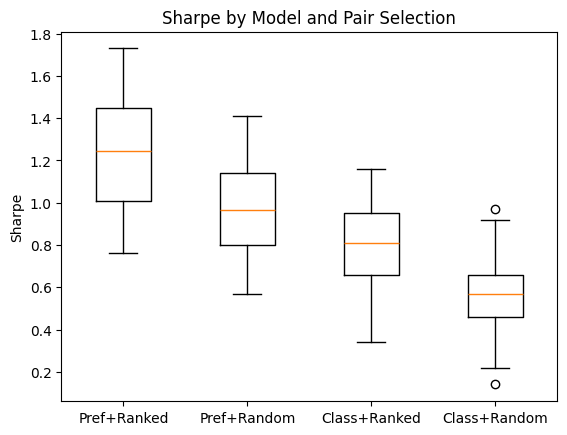

<Figure size 640x480 with 0 Axes>

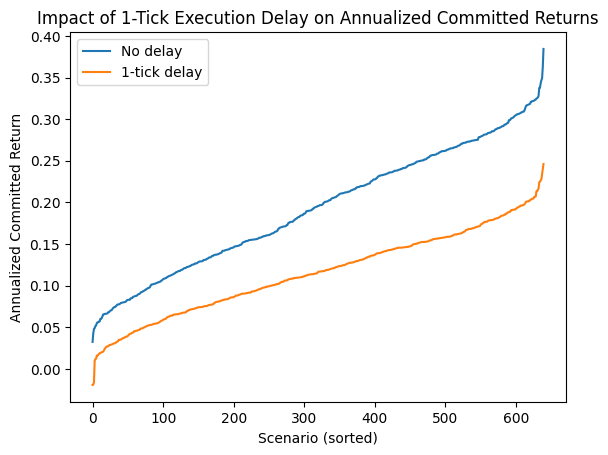

<Figure size 640x480 with 0 Axes>

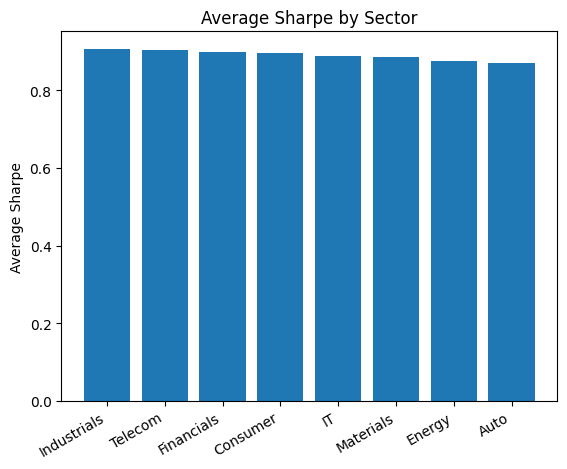

<Figure size 640x480 with 0 Axes>

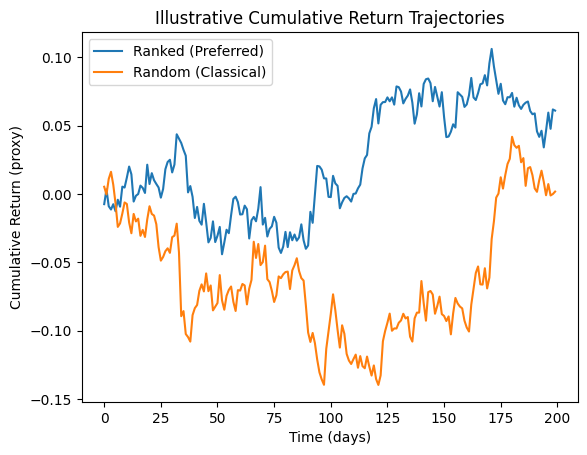

Charts:
- data/charts/sharpe_by_model_selection.png
- data/charts/delay_impact.png
- data/charts/sector_sharpe.png
- data/charts/cumulative_proxy.png


<Figure size 640x480 with 0 Axes>

In [8]:
# 2) Charts → PNGs


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "data/"
pair_kpis = pd.read_csv(os.path.join(BASE_DIR, "pair_level_kpis.csv"))

charts_dir = os.path.join(BASE_DIR, "charts")
os.makedirs(charts_dir, exist_ok=True)

# 1) Sharpe by model & selection (boxplot)
fig = plt.figure()
box_data = [
    pair_kpis[(pair_kpis.model=="Preferred")&(pair_kpis.pair_selection=="Ranked")]["sharpe"].values,
    pair_kpis[(pair_kpis.model=="Preferred")&(pair_kpis.pair_selection=="Random")]["sharpe"].values,
    pair_kpis[(pair_kpis.model=="Classical")&(pair_kpis.pair_selection=="Ranked")]["sharpe"].values,
    pair_kpis[(pair_kpis.model=="Classical")&(pair_kpis.pair_selection=="Random")]["sharpe"].values,
]

plt.boxplot(box_data, labels=["Pref+Ranked","Pref+Random","Class+Ranked","Class+Random"])
plt.title("Sharpe by Model and Pair Selection")
plt.ylabel("Sharpe")
chart1_path = os.path.join(charts_dir, "sharpe_by_model_selection.png")
plt.show()
plt.savefig(chart1_path, dpi=220, bbox_inches="tight"); plt.close(fig)


# 2) Impact of 1-tick delay
fig = plt.figure()
means_no_delay = pair_kpis[pair_kpis.exec_delay_ticks==0]["committed_return_annual"].values
means_delay = pair_kpis[pair_kpis.exec_delay_ticks==1]["committed_return_annual"].values
x = np.arange(min(len(means_no_delay), len(means_delay)))
plt.plot(x, np.sort(means_no_delay)[:len(x)], label="No delay")
plt.plot(x, np.sort(means_delay)[:len(x)], label="1-tick delay")
plt.title("Impact of 1-Tick Execution Delay on Annualized Committed Returns")
plt.xlabel("Scenario (sorted)"); plt.ylabel("Annualized Committed Return"); plt.legend()
chart2_path = os.path.join(charts_dir, "delay_impact.png")
plt.show()
plt.savefig(chart2_path, dpi=220, bbox_inches="tight"); plt.close(fig)


# 3) Sector breakdown (avg Sharpe)
fig = plt.figure()
sector_sr = pair_kpis.groupby("sector")["sharpe"].mean().sort_values(ascending=False)
plt.bar(np.arange(len(sector_sr)), sector_sr.values)
plt.xticks(np.arange(len(sector_sr)), sector_sr.index, rotation=30, ha="right")
plt.ylabel("Average Sharpe"); plt.title("Average Sharpe by Sector")
chart3_path = os.path.join(charts_dir, "sector_sharpe.png")
plt.show()
plt.savefig(chart3_path, dpi=220, bbox_inches="tight"); plt.close(fig)



# 4) Illustrative cumulative returns (synthetic)
fig = plt.figure()
n = 200
cum_ranked = np.cumsum(np.random.normal(0.15/252, 0.01, n))
cum_random = np.cumsum(np.random.normal(0.08/252, 0.012, n))
plt.plot(np.arange(n), cum_ranked, label="Ranked (Preferred)")
plt.plot(np.arange(n), cum_random, label="Random (Classical)")
plt.title("Illustrative Cumulative Return Trajectories")
plt.xlabel("Time (days)"); plt.ylabel("Cumulative Return (proxy)"); plt.legend()
chart4_path = os.path.join(charts_dir, "cumulative_proxy.png")
plt.show()
plt.savefig(chart4_path, dpi=220, bbox_inches="tight"); plt.close(fig)

print("Charts:", chart1_path, chart2_path, chart3_path, chart4_path, sep="\n- ")




In [4]:
# 3) Excel KPI workbook (.xlsx)

import os
import numpy as np
import pandas as pd

BASE_DIR = "data/"
pair_kpis = pd.read_csv(os.path.join(BASE_DIR, "pair_level_kpis.csv"))
portfolio_kpis = pd.read_csv(os.path.join(BASE_DIR, "portfolio_kpis.csv"))

excel_path = os.path.join(BASE_DIR, "NSE_PairsTrading_KPIs.xlsx")
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    portfolio_kpis.to_excel(writer, sheet_name="Summary", index=False)
    pair_kpis.head(100).to_excel(writer, sheet_name="SamplePairs", index=False)
    sr_by_model = pair_kpis.pivot_table(index=["model","pair_selection"],
                                        values="sharpe", aggfunc=np.mean).reset_index()
    sr_by_model.to_excel(writer, sheet_name="SharpeByModelSel", index=False)
    sector_breakdown = pair_kpis.groupby("sector").agg(
        avg_sharpe=("sharpe","mean"),
        avg_committed_return=("committed_return_annual","mean"),
        trades=("num_trades","sum")
    ).reset_index()
    sector_breakdown.to_excel(writer, sheet_name="SectorBreakdown", index=False)
    print(sector_breakdown)


print("Excel KPI workbook:", excel_path)

        sector  avg_sharpe  avg_committed_return  trades
0         Auto    0.871406              0.155005   11220
1     Consumer    0.897617              0.156001   23112
2       Energy    0.875625              0.153481   11269
3   Financials    0.899844              0.153699   23086
4           IT    0.889609              0.154899   11313
5  Industrials    0.906563              0.154495   11228
6    Materials    0.887031              0.151471   11298
7      Telecom    0.903672              0.151377   11221
Excel KPI workbook: data/NSE_PairsTrading_KPIs.xlsx


/tmp/ipython-input-3147344303.py:15: FutureWarning: The provided callable <function mean at 0x7ed78bd2c220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sr_by_model = pair_kpis.pivot_table(index=["model","pair_selection"],


In [5]:

# analysis_pipeline
# Skeleton pipeline for HF pairs trading
# Usage: python analysis_pipeline
import pandas as pd

BASE_DIR = "data/"

pair_kpis = pd.read_csv(f"{BASE_DIR}pair_level_kpis.csv")
portfolio_kpis = pd.read_csv(f"{BASE_DIR}portfolio_kpis.csv")

# Example: compute additional summaries
sr_by_model_sel = pair_kpis.groupby(["model","pair_selection"])["sharpe"].mean().reset_index()
sr_by_model_sel.to_csv(f"{BASE_DIR}summary_sharpe_by_model_selection.csv", index=False)
print(sr_by_model_sel)

print("summary_sharpe_by_model_selection.csv")




       model pair_selection    sharpe
0  Classical         Random  0.562656
1  Classical         Ranked  0.802937
2  Preferred         Random  0.973531
3  Preferred         Ranked  1.232406
summary_sharpe_by_model_selection.csv


In [6]:
## Print all the pair level and portfolio level KPI

import pandas as pd
pair_kpis = pd.read_csv('data/pair_level_kpis.csv')
portfolio_kpis = pd.read_csv('data/portfolio_kpis.csv')
pair_kpis.head(), portfolio_kpis

(     pair_a pair_b  sector  tick_minutes      model pair_selection  \
 0  RELIANCE   BPCL  Energy             5  Classical         Ranked   
 1  RELIANCE   BPCL  Energy             5  Classical         Ranked   
 2  RELIANCE   BPCL  Energy             5  Classical         Ranked   
 3  RELIANCE   BPCL  Energy             5  Classical         Ranked   
 4  RELIANCE   BPCL  Energy             5  Classical         Ranked   
 
   position_policy cointegration_policy  exec_delay_ticks  param_grid_size  \
 0           Carry         RollingCheck                 0               16   
 1           Carry         RollingCheck                 1               16   
 2           Carry            SkipCheck                 0               16   
 3           Carry            SkipCheck                 1               16   
 4        EOD_Flat         RollingCheck                 0               16   
 
    sharpe  committed_return_annual  invested_return_annual  num_trades  \
 0    1.00                 